In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.utils.data import random_split
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import csv
import seaborn as sns

In [ ]:
train = 'drive/MyDrive/Colab Notebooks/lab_3/dog-breed-identification/train/'
test = 'drive/MyDrive/Colab Notebooks/lab_3/dog-breed-identification/test/'
csv_file_train = 'drive/MyDrive/Colab Notebooks/lab_3/dog-breed-identification/labels.csv'

{'dingo': 80, 'pekinese': 75, 'bluetick': 85, 'golden_retriever': 67, 'bedlington_terrier': 89, 'borzoi': 75, 'basenji': 110, 'scottish_deerhound': 126, 'shetland_sheepdog': 76, 'walker_hound': 69, 'maltese_dog': 117, 'norfolk_terrier': 83, 'african_hunting_dog': 86, 'wire-haired_fox_terrier': 82, 'redbone': 72, 'lakeland_terrier': 99, 'boxer': 75, 'doberman': 74, 'otterhound': 69, 'standard_schnauzer': 72, 'irish_water_spaniel': 78, 'black-and-tan_coonhound': 77, 'cairn': 106, 'affenpinscher': 80, 'labrador_retriever': 84, 'ibizan_hound': 91, 'english_setter': 83, 'weimaraner': 85, 'giant_schnauzer': 69, 'boston_bull': 86, 'groenendael': 82, 'dhole': 76, 'toy_poodle': 80, 'border_terrier': 91, 'tibetan_terrier': 107, 'norwegian_elkhound': 95, 'shih-tzu': 112, 'irish_terrier': 82, 'kuvasz': 71, 'german_shepherd': 69, 'greater_swiss_mountain_dog': 82, 'basset': 82, 'australian_terrier': 102, 'schipperke': 86, 'rhodesian_ridgeback': 88, 'irish_setter': 88, 'appenzeller': 78, 'bloodhound'

<Axes: >

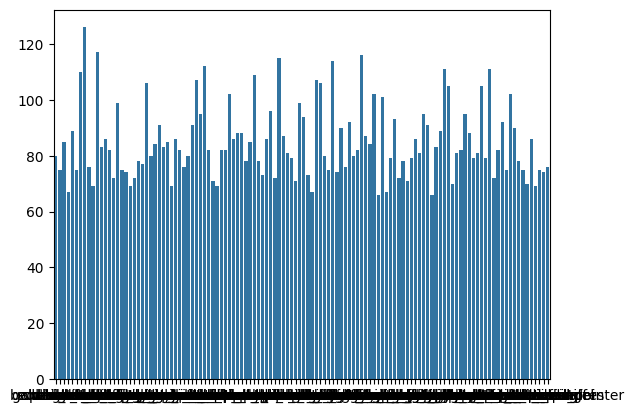

In [ ]:
read_csv_file_train = pd.read_csv(csv_file_train)
counter = {}
for breed in read_csv_file_train['breed'][1:]:
     counter[breed] = counter.get(breed, 0) + 1
print(counter)
X = [key for key in counter.keys()]
Y = [value for value in counter.values()]
sns.barplot(x=X, y=Y)

In [ ]:
breed_to_idx = {breed: i for i, breed in enumerate(pd.read_csv(csv_file_train)['breed'].unique())}

class DatasetToClass(torch.utils.data.Dataset):
    def __init__(self, pictures, csv_file):
        super().__init__()
        self.pictures = pictures
        self.data = pd.read_csv(csv_file)
        self.pictures_list = os.listdir(pictures)

    def __len__(self):
        return len(self.pictures_list)

    def __getitem__(self, index):
        img_name = self.data.iloc[index, 0]
        img_path = os.path.join(self.pictures, str(img_name)+'.jpg')
        label = self.data.iloc[index, 1]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0

        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1))

        img = torch.from_numpy(img)
        label = torch.tensor(breed_to_idx[label])

        return img, label

train_breed_dogs = DatasetToClass(train, csv_file_train)

num_train = int(0.8 * len(train_breed_dogs))
num_valid = len(train_breed_dogs) - num_train
train_data, valid_data = random_split(train_breed_dogs, [num_train, num_valid])

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

In [ ]:
class DogBreedClassification(nn.Module):
    def __init__(self, num_classes):
        super(DogBreedClassification, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
def validate_model(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for xb, yb in valid_loader:
            pred = model(xb.to(device))
            loss = loss_fn(pred, yb.to(device))

            val_loss += loss.item()
            correct += (pred.argmax(1) == yb.to(device)).type(torch.float).sum().item()
            total += len(xb.to(device))

    accuracy = correct / total
    return val_loss, accuracy

  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1, Validation Loss: 4.6353, Accuracy: 0.0166
Epoch [1/4], Loss: 4.7320


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 2, Validation Loss: 4.5332, Accuracy: 0.0284
Epoch [2/4], Loss: 4.5140


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 3, Validation Loss: 4.4689, Accuracy: 0.0347
Epoch [3/4], Loss: 4.2750


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 4, Validation Loss: 4.7552, Accuracy: 0.0411
Epoch [4/4], Loss: 3.7588


  0%|          | 0/10377 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
76680349c01ea89d2ca18f90b0776542.jpg    whippet    0.0962252467870712
6b350b0a892207ba23555ad90ce0fd52.jpg    australian_terrier    0.0613659955561161
6c959ab8926c4699bcab8bb414b6a78f.jpg    irish_water_spaniel    0.042700920253992
68db470841f1ecf43658c30e82fccd30.jpg    cairn    0.0408189110457897
73a0ce1b884a24ddf99d24b79d5f3278.jpg    maltese_dog    0.0406698435544967
6b6824bfade1e9501e048787d27e35fe.jpg    soft-coated_wheaten_terrier    0.0660824701189994
6d3074c31b898a5f3d0d688c14447089.jpg    sealyham_terrier    0.1641817092895507
6fc886ae22650ecdb5ac911cb621a077.jpg    miniature_schnauzer    0.0627521201968193
67ef5ebdcf70dd4bd3619afe809093aa.jpg    dingo    0.0459419190883636
6765b2e22a3152dc2f645438bd6bfb8c.jpg    blenheim_spaniel    0.0321875587105751
6922b815d5dc1d70a106e305f433ff10.jpg    blenheim_spaniel    0.0281934197992086
6ea8fdcda47c463267d1393f45bcad25.jpg    leonberg    0.157694786787033
6b7c98326b6

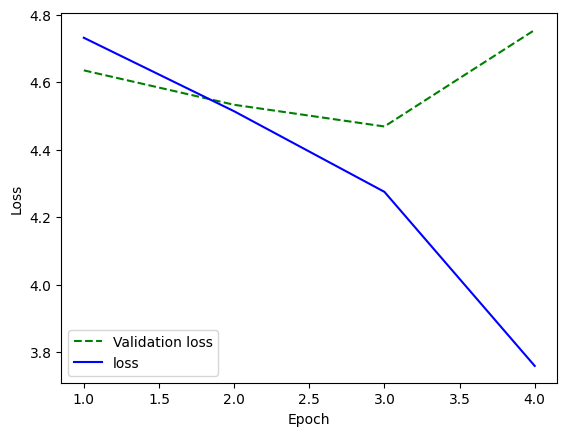

In [ ]:
num_breeds = 120
model = DogBreedClassification(num_breeds)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_arr = []
val_loss_arr = []
epoch_arr = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    val_loss, accuracy = validate_model(model, valid_loader, criterion)
    epoch_val_loss = val_loss / len(valid_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {epoch_val_loss:.4f}, Accuracy: {accuracy:.4f}')
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    loss_arr.append(epoch_loss)
    val_loss_arr.append(epoch_val_loss)
    epoch_arr.append(epoch+1)

model.eval()
test_images = os.listdir(test)
results = []

with torch.no_grad():
    for image_name in tqdm(test_images):
        img_path = os.path.join(test, image_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1))

        img = torch.from_numpy(img)

        outputs = model(img.to(device))
        probabilities = torch.softmax(outputs, dim=1).squeeze().tolist()

        result = [image_name] + probabilities
        results.append(result)

breed_names = pd.read_csv(csv_file_train).iloc[:, 1].unique()
header = ['image_name'] + list(breed_names)

with open('drive/MyDrive/Colab Notebooks/lab_3/results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(results)

results_df = pd.read_csv('drive/MyDrive/Colab Notebooks/lab_3/results.csv')
for i in range(10357):
    dict_breed = zip([k for k in results_df[:]][1:], [k for k in results_df.iloc[i, :]][1:])
    mx_ = max(dict_breed, key=lambda x: x[1])
    breed, probability = mx_[0], mx_[1]
    print(results_df.iloc[i, 0], breed, probability, sep='    ')

plt.plot(epoch_arr, val_loss_arr, label='Validation loss', color='green', linestyle='dashed')
plt.plot(epoch_arr, loss_arr, label='loss', color='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = tv.models.resnet50(weights=tv.models.ResNet50_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 120)
model = model.to(device)
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):

        outputs = model(images.to(device))
        optimizer.zero_grad()
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    val_loss, accuracy = validate_model(model, valid_loader, criterion)
    epoch_val_loss = val_loss / len(valid_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {epoch_val_loss:.4f}, Accuracy: {accuracy:.4f}')
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

model.eval()
test_images = os.listdir(test)
breed_res = []

with torch.no_grad():
    for image_name in tqdm(test_images):
        img_path = os.path.join(test, image_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1))

        img = torch.from_numpy(img)
        img = img.to(device)
        outputs = model(img.unsqueeze(0))
        probabilities = torch.softmax(outputs, dim=1).squeeze().tolist()

        result = [image_name] + probabilities
        breed_res.append(result)

breed_names_resnet = pd.read_csv(csv_file_train).iloc[:, 1].unique()
header = ['image_name'] + list(breed_names)

with open('drive/MyDrive/Colab Notebooks/lab_3/results_resnet.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(results)


results_df = pd.read_csv('drive/MyDrive/Colab Notebooks/lab_3/results_resnet.csv')
for i in range(10357):
    dict_breed = zip([k for k in results_df[:]][1:], [k for k in results_df.iloc[i, :]][1:])
    mx_ = max(dict_breed, key=lambda x: x[1])
    breed, probability = mx_[0], mx_[1]
    print(results_df.iloc[i, 0], breed, probability, sep='    ')

  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 1, Validation Loss: 4.6757, Accuracy: 0.0205
Epoch [1/10], Loss: 4.8015


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 2, Validation Loss: 4.4392, Accuracy: 0.0313
Epoch [2/10], Loss: 4.6009


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 3, Validation Loss: 4.4645, Accuracy: 0.0303
Epoch [3/10], Loss: 4.3474


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 4, Validation Loss: 4.0683, Accuracy: 0.0636
Epoch [4/10], Loss: 4.0811


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 5, Validation Loss: 4.1536, Accuracy: 0.0572
Epoch [5/10], Loss: 3.8292


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch 6, Validation Loss: 3.8410, Accuracy: 0.0998
Epoch [6/10], Loss: 3.5957


  0%|          | 0/256 [00:00<?, ?it/s]